<a href="https://colab.research.google.com/github/NiklasElsaesser/FaceBias/blob/main/FaceBias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

\For labeling, the pictures have been structured in a folder structure which looks like this:

<img src="drawing.jpg" alt="drawing" width="200"/>

# Project "Bias in Face-Detection"


Installing necessary libraries
1.   OpenCV to preprocess the data (pictures)  
2.   numpy to organize the data and link it with the labels



In [1]:
!pip install opencv-contrib-python
!pip install numpy as np
!pip install tensorflow
!pip install wandb

ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as


Import the W&B library and initialize your W&B project at the beginning of your Colab notebook:

In [2]:
import wandb
wandb.init(project="4facesbias")

wandb: Currently logged in as: elsaesserniklas. Use `wandb login --relogin` to force relogin


Mounting a Google Drive where the pictures are uploaded from.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now the pictures get loaded and preprocessed.

In [4]:
import os
import cv2
import numpy as np

data = []
labels = []

genders = ["men","women"]
emotions = ["happy","neutral"]

for gender in genders:
    for emotion in emotions:
        folder_path = f'/content/drive/MyDrive/Faces/Dataset/{gender}/{emotion}/'
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
            if img is None:
              print("error")
              continue
            img = cv2.resize(img, (48, 48))
            data.append(img)
            # Create labels by combining gender and emotion indices
            label = genders.index(gender) * len(emotions) + emotions.index(emotion)
            labels.append(label)

data = np.array(data)
data = data.reshape((data.shape[0], 48, 48, 1))
labels = np.array(labels)


error


Now Splitting the Data into a training and test set in an 80 - 20 config.

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

Building and training of the model.

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(len(genders) * len(emotions), activation='softmax'))  # Output layer with appropriate number of units

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

wandb_callback = wandb.keras.WandbCallback()

model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=64)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10
3/3 [==============================] - 3s 556ms/step - loss: 88.9424 - accuracy: 0.3257 - val_loss: 274.9419 - val_accuracy: 0.5227
Epoch 2/10
3/3 [==============================] - 2s 718ms/step - loss: 136.3899 - accuracy: 0.6000 - val_loss: 72.3349 - val_accuracy: 0.4773
Epoch 3/10
3/3 [==============================] - 2s 715ms/step - loss: 65.7418 - accuracy: 0.4000 - val_loss: 0.7065 - val_accuracy: 0.8636
Epoch 4/10
3/3 [==============================] - 2s 672ms/step - loss: 0.3971 - accuracy: 0.9143 - val_loss: 0.2286 - val_accuracy: 0.9318
Epoch 5/10
3/3 [==============================] - 1s 434ms/step - loss: 0.1382 - accuracy: 0.9543 - val_loss: 0.2279 - val_accuracy: 0.9318
Epoch 6/10
3/3 [==============================] - 1s 386ms/step - loss: 0.1698 - accuracy: 0.9543 - val_loss: 0.0061 - val_accuracy: 1.0000
Epoch 7/10
3/3 [==============================] - 1s 395ms/step - loss: 0.0257 - accuracy: 0.9886 - val_loss: 2.2080e-06 - val_accuracy: 1.0000
Epoch 8/1

In [7]:
wandb_callback = wandb.keras.WandbCallback()
#history = model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(val_images, val_labels), callbacks=[wandb_callback])


checking for loss and accuracy.

In [12]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss:.2f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

2/2 [==============================] - 0s 32ms/step - loss: 2.3109e-06 - accuracy: 1.0000
Test Loss: 0.00
Test Accuracy: 100.00%


Saving the trained model to the GDrive

In [13]:
from google.colab import drive
drive.mount('/content/drive')

# Save the model to Google Drive
model.save('bias_model.keras')
#model.save('/content/drive/MyDrive/Faces/Dataset/emotion_model.h5')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Testing the Model
Here we upload a new picture and test if the model recognizes the face according to the trained labels and **if** the model has any bias towards men that smile.

allow for the input of a new picture on which the algorithm wasnt trained to test for the bias of the algorithm.

In [14]:
!pip install matplotlib
!pip install opencv-contrib-python

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1/1 [==============================] - 0s 80ms/step
Predicted Gender: Women
Predicted Emotion: Happy


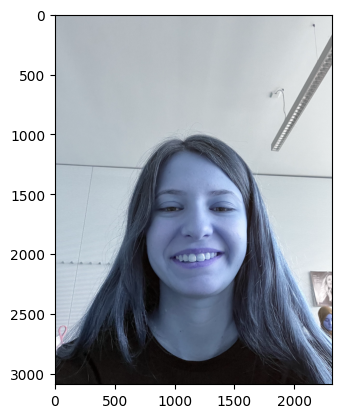

In [18]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt


# Load your face recognition model
face_emotion_model_path = '/content/drive/MyDrive/Faces/Dataset/emotion_model.h5'
face_recognition_model = load_model(face_emotion_model_path)

# Function to preprocess images
def preprocess_image(img):
    img = cv2.resize(img, (48, 48))
    img = img.astype('float') / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    return img

# File path to the uploaded image
uploaded_img_path = '/content/drive/MyDrive/Faces/testing/IMG_9580.jpg'

# Read the uploaded image
img = cv2.imread(uploaded_img_path, cv2.IMREAD_GRAYSCALE)
if img is None:
    print("Error: Unable to read the image.")
else:
    # Preprocess the image
    processed_img = preprocess_image(img)
    # Predict gender using the model
    predicted_gender = face_recognition_model.predict(processed_img)

    # Map the predicted index to gender and emotion labels
    genders = ["men", "women"]
    emotions = ["happy", "neutral"]

    gender_index = np.argmax(predicted_gender)
    gender_label = genders[gender_index // len(emotions)]
    emotion_label = emotions[gender_index % len(emotions)]

    # Print the predicted gender and emotion
    print(f"Predicted Gender: {gender_label.capitalize()}")
    print(f"Predicted Emotion: {emotion_label.capitalize()}")

    faceImg = cv2.imread(uploaded_img_path)
    plt.imshow(faceImg)
